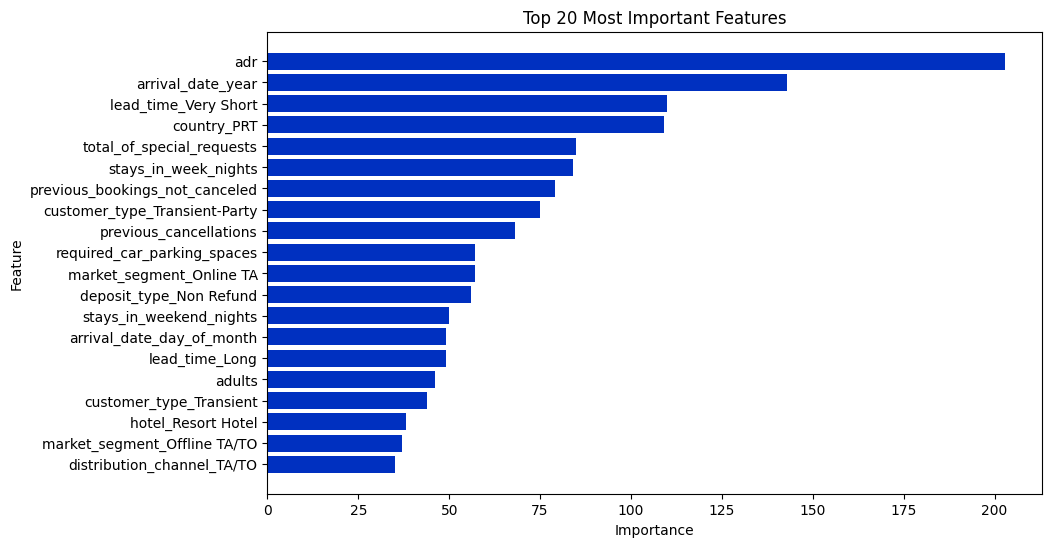

,Feature,Importance
0,adr,203.0
1,arrival_date_year,143.0
2,lead_time_Very Short,110.0
3,country_PRT,109.0
4,total_of_special_requests,85.0
5,stays_in_week_nights,84.0
6,previous_bookings_not_canceled,79.0
7,customer_type_Transient-Party,75.0
8,previous_cancellations,68.0
9,required_car_parking_spaces,57.0


In [30]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the full dataset again (replace 'ocean_final.csv' with your actual file path)
ocean_crest_data = pd.read_csv('ocean_final.csv')
# Drop the 'reservation_status' column
ocean_crest_data = ocean_crest_data.drop(columns=['reservation_status'])

# Define X (features) and y (target)
X_train_full = ocean_crest_data.drop(columns=['is_canceled'])  # 'is_canceled' is the target variable
y_train = ocean_crest_data['is_canceled']  # 'is_canceled' is the column we're predicting

# One-hot encode categorical columns if necessary
X_train_full = pd.get_dummies(X_train_full, drop_first=True)

# Fit the model on the reduced dataset (without 'reservation_status')
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, min_child_weight=1, learning_rate=0.1)
xgb_model.fit(X_train_full, y_train)

# Extract feature importance in dictionary format
importance = xgb_model.get_booster().get_score(importance_type='weight')

# If feature names are already actual column names (like after one-hot encoding)
mapped_importance = {feature: score for feature, score in importance.items()}

# Sort the features by importance (in descending order)
sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)

# Show only the top 10 most important features
top_10_importance = sorted_importance[:20]

# Convert the top 10 importance to a DataFrame for easy plotting
importance_df = pd.DataFrame(top_10_importance, columns=['Feature', 'Importance'])


# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#0030c0')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

importance_df


AUC for Training Data: 0.9264202345321262
AUC for Testing Data: 0.9247743022492028


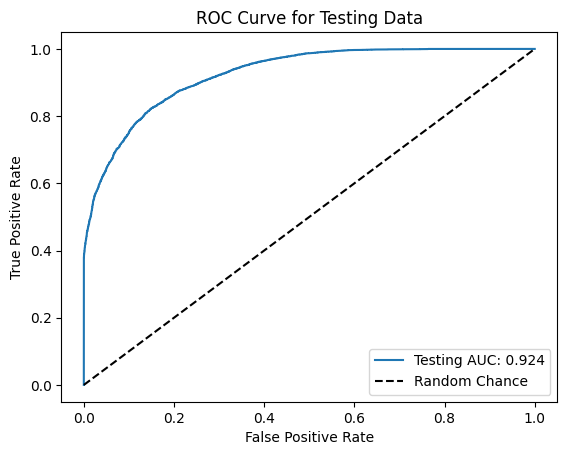

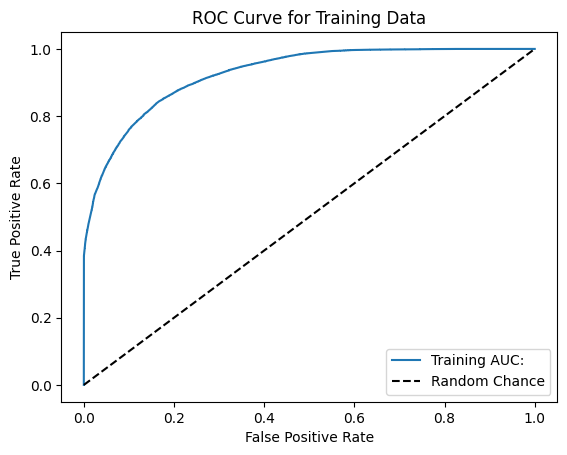

In [31]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Load the dataset
ocean_crest_data = pd.read_csv('ocean_final.csv')

# Drop the 'reservation_status' column
ocean_crest_data = ocean_crest_data.drop(columns=['reservation_status'])

# Define X (features) and y (target)
X = ocean_crest_data.drop(columns=['is_canceled'])  # Features
y = ocean_crest_data['is_canceled']  # Target

# One-hot encode categorical columns if necessary
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training dataset
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, min_child_weight=1, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict probabilities on the training and testing sets
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]  # Probability for the positive class (canceled)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC score for training and testing data
auc_train = roc_auc_score(y_train, y_train_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)

# Print AUC values
print(f"AUC for Training Data: {auc_train}")
print(f"AUC for Testing Data: {auc_test}")

# Plot ROC curve for the testing data
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.plot(fpr, tpr, label=f'Testing AUC: 0.924')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Testing Data')
plt.legend()
plt.show()

# Plot ROC curve for the training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
plt.plot(fpr_train, tpr_train, label=f'Training AUC:')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.show()


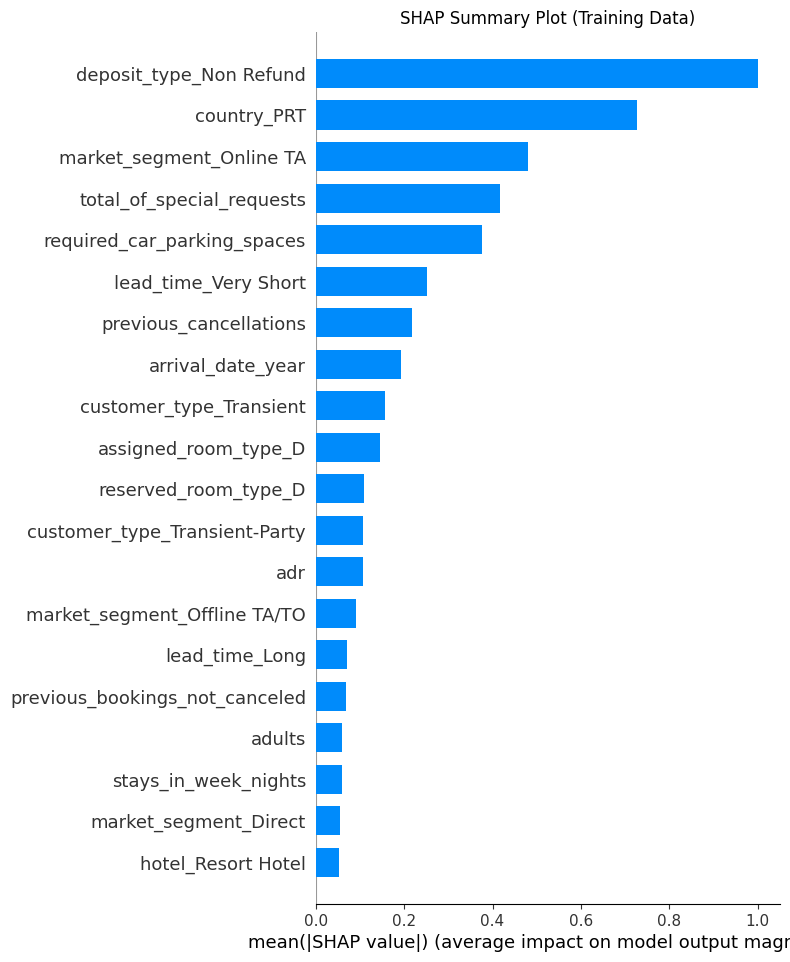

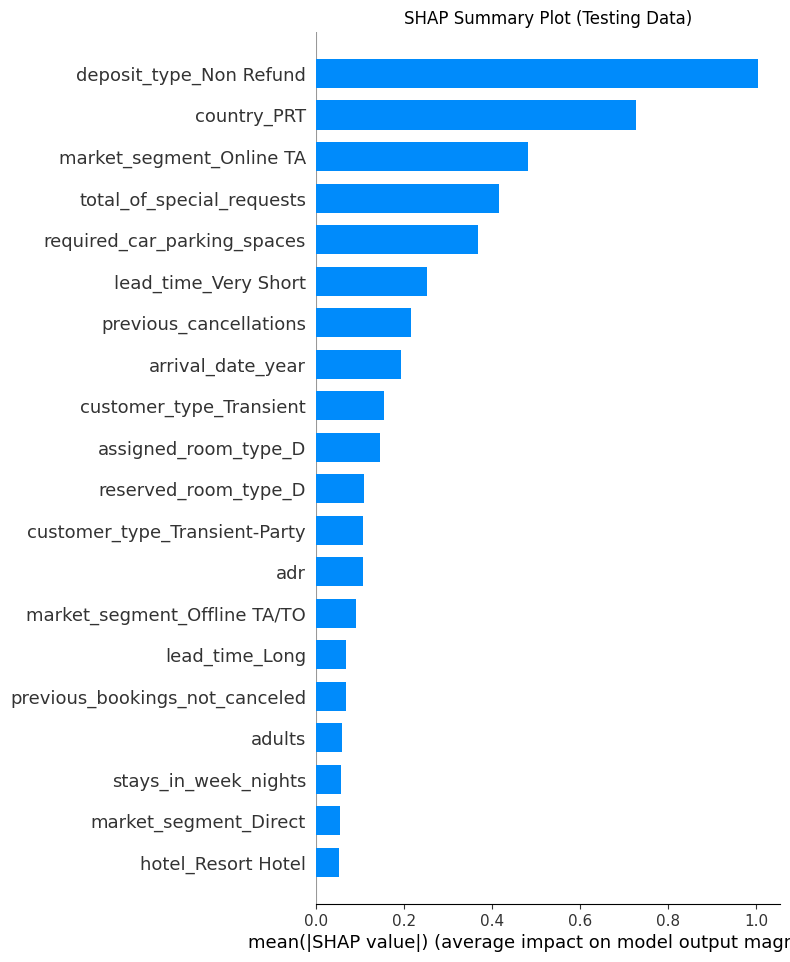

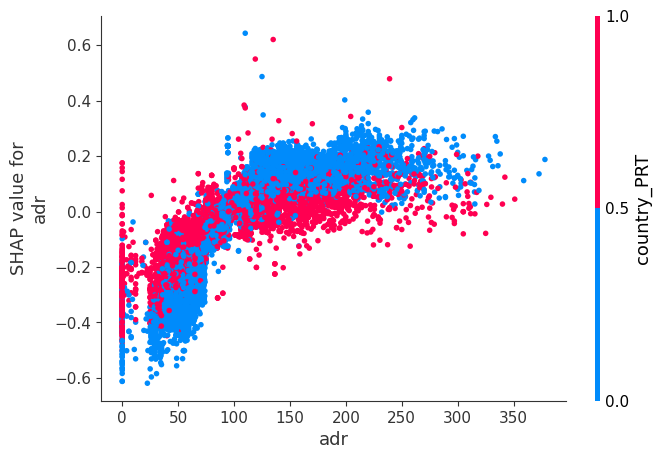

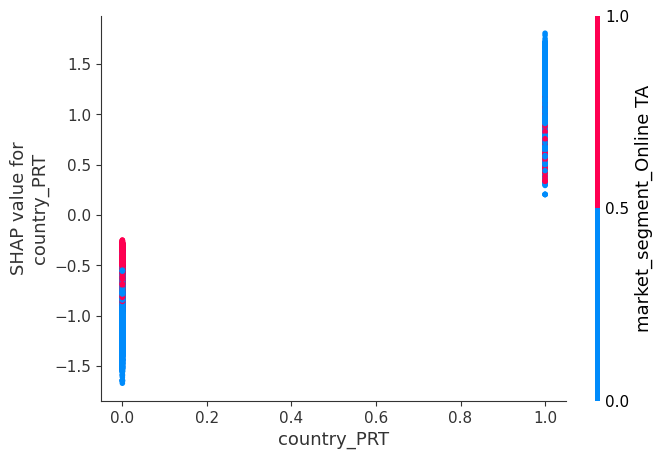

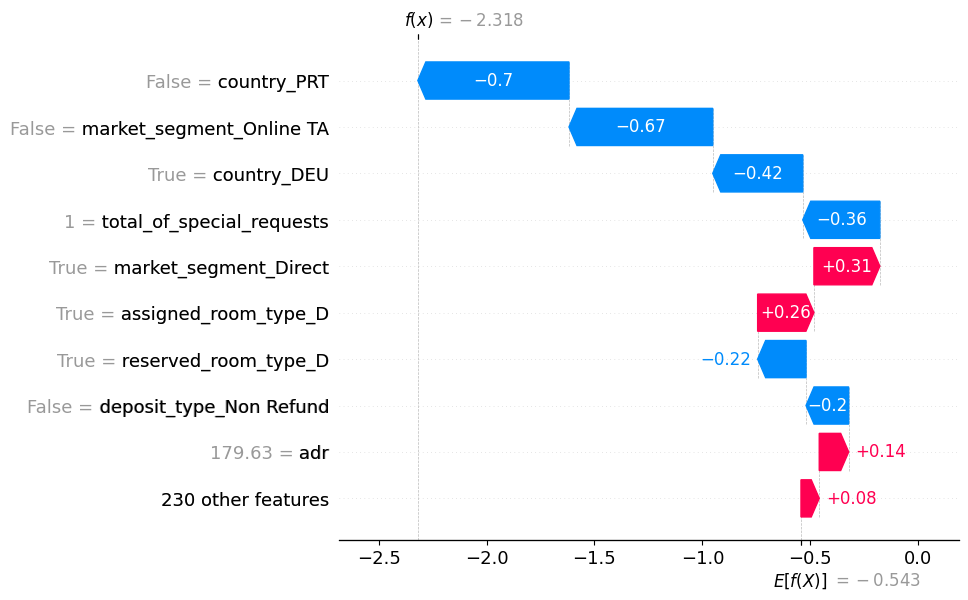

In [38]:
import shap

# Create a SHAP explainer based on the trained model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the training set
shap_values_train = explainer(X_train)

# Plot SHAP summary plot for the training data
shap.summary_plot(shap_values_train, X_train, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (Training Data)')
plt.show()

# Calculate SHAP values for the testing set
shap_values_test = explainer(X_test)

# Plot SHAP summary plot for the testing data
shap.summary_plot(shap_values_test, X_test, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (Testing Data)')
plt.show()

# Optional: Plot SHAP dependence plot for a specific feature (example: 'adr')
shap.dependence_plot('adr', shap_values_test.values, X_test)
# Optional: Plot SHAP dependence plot for a specific feature (example: 'adr')
shap.dependence_plot('country_PRT', shap_values_test.values, X_test)


# Optional: SHAP waterfall plot for a specific prediction (e.g., the first test sample)
shap.waterfall_plot(shap_values_test[0])


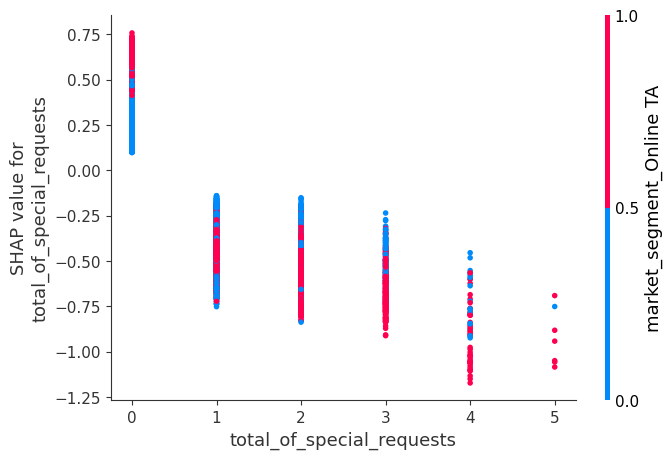

In [39]:
# Optional: Plot SHAP dependence plot for a specific feature (example: 'adr')
shap.dependence_plot('total_of_special_requests', shap_values_test.values, X_test)

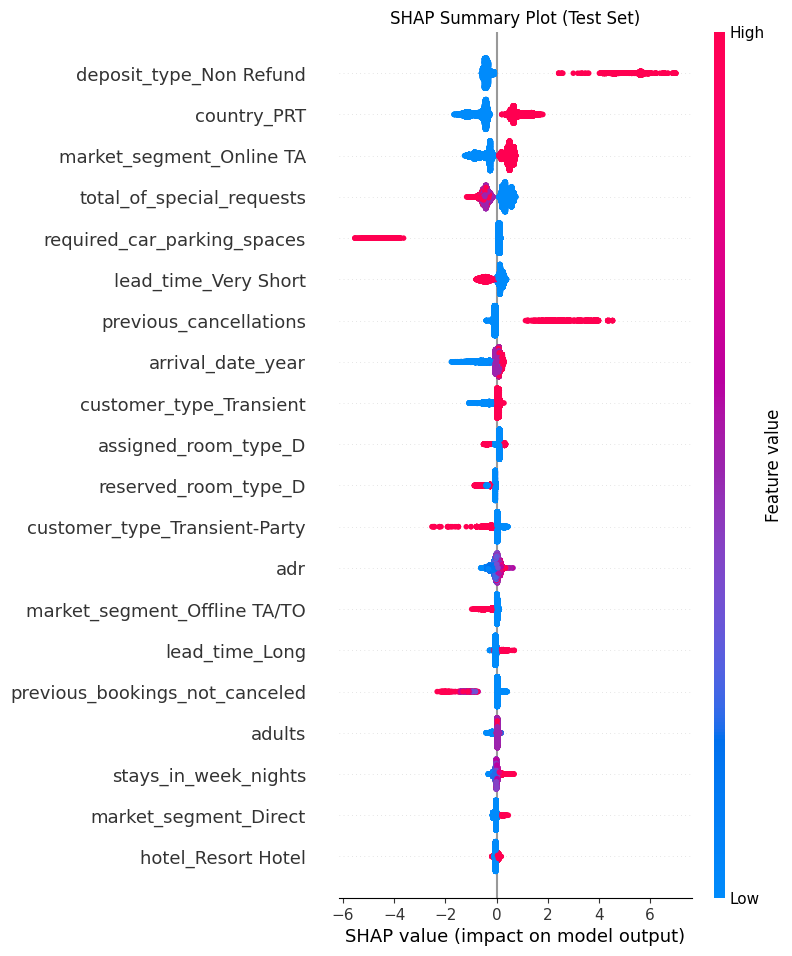

In [20]:

# Initialize the SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot (impact of top features)
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('SHAP Summary Plot (Test Set)')
plt.show()


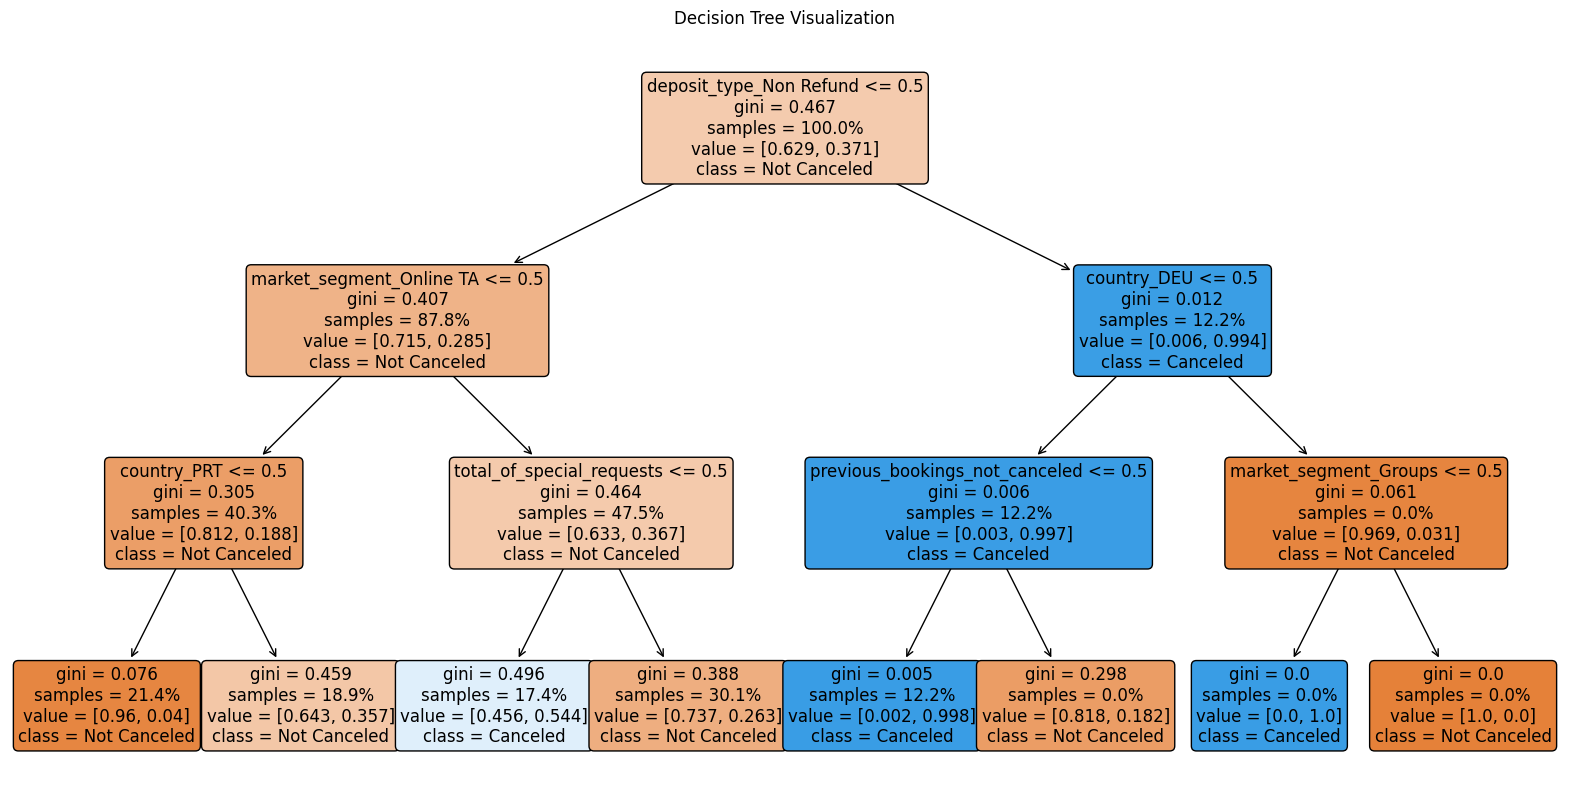

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Assuming you have X and y ready from previous steps
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Plot the decision tree with larger font size
plt.figure(figsize=(20,10))  # Adjust figure size for better visualization
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=["Not Canceled", "Canceled"], 
          rounded=True, proportion=True, fontsize=12)  # Increase fontsize to 12 or more
plt.title('Decision Tree Visualization')
plt.show()


In [1]:
# Ensure you're looping through column names of the DataFrame
#for c in X_train.columns:  # Replace X_train with X_train_full_reduced if necessary
 #   print(f"{c} -->")
  #  print(X_train[c].value_counts())  # Replace X_train with X_train_full_reduced if necessary
  #  print('\n\n')


In [8]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
holdout_data= pd.read_csv("ocean_holdout_modified.csv")

In [14]:
import pandas as pd
import xgboost as xgb

# Load the holdout data
holdout_data = pd.read_csv("ocean_holdout_modified.csv")

# Remove the same variables as in the original dataset (dropping 'reservation_status' and any other necessary columns)

# One-hot encode the holdout data in the same way as your training data
holdout_data_encoded = pd.get_dummies(holdout_data, drop_first=True)

# Ensure that the holdout set has the same columns as the training data (X_train_full)
# If any columns are missing in the holdout data, add them with a default value of 0
for col in X_train_full.columns:
    if col not in holdout_data_encoded.columns:
        holdout_data_encoded[col] = 0

# Align the columns of holdout_data_encoded to match the order of X_train_full
holdout_data_encoded = holdout_data_encoded[X_train_full.columns]

# Predict the probabilities of cancellation using the fitted XGBoost model
case_holdout_prob = xgb_model.predict_proba(holdout_data_encoded)

# Add the predicted probabilities to the holdout dataset
holdout_data_encoded['predicted_prob_cancel'] = case_holdout_prob[:, 1]  # Assuming you're interested in the 'is_canceled' probability

# Combine holdout data with predicted probabilities
case_holdout_scored = pd.concat([holdout_data_encoded, pd.Series(case_holdout_prob[:, 1], name='predicted_prob_cancel')], axis=1)

# View the first 3 rows of the scored dataset
print(case_holdout_scored.head(3))




   arrival_date_year  arrival_date_day_of_month  stays_in_weekend_nights  \
0               2015                          1                        0   
1               2015                          1                        0   
2               2015                          1                        0   

   stays_in_week_nights  adults  is_repeated_guest  previous_cancellations  \
0                     2       2                  0                       0   
1                     3       2                  0                       0   
2                     4       2                  0                       0   

   previous_bookings_not_canceled  days_in_waiting_list     adr  ...  \
0                               0                     0   98.00  ...   
1                               0                     0   82.00  ...   
2                               0                     0  154.77  ...   

   continent_Antarctica  continent_Asia  continent_Australia  \
0                     0      

/var/folders/nx/kw42myj118qcfhjblyggj0z40000gn/T/ipykernel_58756/2113202248.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout_data_encoded[col] = 0
/var/folders/nx/kw42myj118qcfhjblyggj0z40000gn/T/ipykernel_58756/2113202248.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout_data_encoded[col] = 0
/var/folders/nx/kw42myj118qcfhjblyggj0z40000gn/T/ipykernel_58756/2113202248.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [40]:
# Save the final dataset with predicted probabilities
case_holdout_scored.to_csv('pleaseeeee.csv', index=False)

In [29]:
print(X_test.columns)


Index(['arrival_date_year', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'days_in_waiting_list', 'adr',
       ...
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_Antarctica', 'continent_Asia', 'continent_Australia',
       'continent_Europe', 'continent_Europe/Asia', 'continent_North America',
       'continent_Oceania', 'continent_South America'],
      dtype='object', length=239)
